<a href="https://colab.research.google.com/github/imran123509/-Reinforcement-Learning-for-Trading/blob/main/Reinforcement_Learning_for_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment TradingEnv-v0
  logger.warn(f"Overriding environment {spec.id}")
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environme

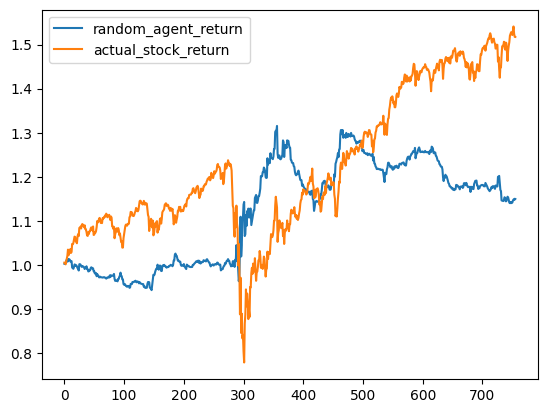

In [47]:
import gym
from gym.envs.registration import register
from gym import error, spaces, utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web

import random
import sys

class TradingEnv(gym.Env):
    def __init__(self, start_date, end_date, tc=0.05/100, ticker='^DJI'):
        self.start = start_date
        self.end = end_date
        self.tc = tc
        self.ticker = ticker

        self.action_space = spaces.Discrete(1)
        self.observation_space = spaces.Box(low=-1,high=1,dtype=np.float32)
        returns = self.load_dataset()
        self.data_df = self.create_features(returns)
        self.curr_index = 0
        self.data_len = self.data_df.shape[0]
        self.action = 0

    def step(self, action):

        done = False
        stock_return = self.extract_return(self.data_df, self.curr_index)
        change_in_position = np.abs(self.action - action)
        cost = change_in_position * self.tc
        reward = action*stock_return - cost

        if self.curr_index == self.data_len - 2:
            done = True
        self.curr_index += 1
        self.action = action

        obs = self.extract_state(self.data_df, self.curr_index).values

        info = { 'date' : self.data_df.index[self.curr_index], 'return' : stock_return }

        return obs, reward, done, info

    def reset(self):
        self.curr_index = 0
        return self.extract_state(self.data_df, self.curr_index).values

    def render(self,mode='human'):
        pass

    def extract_return(self, df, i):
        return df.iloc[i]['Y']

    def extract_state(self, df, i):
        return df.iloc[i][['r%d' % i for i in range(5)]]

    def load_dataset(self):
        df = web.DataReader(self.ticker, 'stooq')
        mask = ( self.start <= df.index ) & ( df.index <= self.end )
        df = df[mask]
        df = df.sort_values(by='Date')
        returns = df['Close'].pct_change()
        return returns

    def create_features(self, returns):
        dfs = []
        for i in range(5):
            dfs.append(returns.shift(i).rename('r%d'%i))
        dfs.append(returns.shift(-1).rename('Y'))
        df_net = pd.concat(dfs, axis=1)
        df_net = df_net.dropna()
        return df_net

ENV_NAME = 'TradingEnv-v0'

reg = register(
    id=ENV_NAME,
    entry_point='__main__:TradingEnv',
    kwargs={
        'start_date' : '2019-01-01',
        'end_date' : '2022-01-10',
    }
)

if __name__ == '__main__':

    env = gym.make(ENV_NAME)
    obs = env.reset()
    done = False

    reward_returns = []
    while not done:
        action = random.uniform(-1,1)
        obs, reward, done, info = env.step(action)
        reward_returns.append( (reward,info['return']) )

    i = list(range(len(reward_returns)))
    agent_returns = np.cumprod([ 1 + x[0] for x in reward_returns ])
    stock_returns = np.cumprod([ 1 + x[1] for x in reward_returns ])

    plt.plot(i, agent_returns, label='random_agent_return')
    plt.plot(i, stock_returns, label='actual_stock_return')
    plt.legend()
    plt.show()